## Project Overview

This project utilizes Yellow Cab data, provided by the  NYC Taxi and Limousine Commission, to predict three different parameters:

1. Total  Fare prediction - Total Amount
2. Elapsed time (ride duration) prediction 
3. "Trip combination" traffic volume 

The data can be found at https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page, with the Yellow Cab data dictionary available at https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf.



In [1]:
# Import packages
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/31 15:09:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/31 15:09:41 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/03/31 15:09:41 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/03/31 15:09:41 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
# Read data
file = "/Users/PengHao/Study/uwaterloo/BigData/groupAssignment/dataAndDesc/yellow_tripdata_2022-03.parquet"
df = spark.read.parquet(file, header = True, inferSchema = True)

In [3]:
df.createOrReplaceTempView("df")

## Data Clean and Feature Engineering

In [4]:
# Print df schema
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [5]:
# Drop missing values from dataframe
df = df.na.drop()

In [6]:
# Drop  duplicates from dataframe
df = df.dropDuplicates()

In [7]:
# Create new feature reflecting elapsed trip times (in seconds)
df = df.withColumn("elapsed_time", (df["tpep_dropoff_datetime"].cast("long")-df["tpep_pickup_datetime"].cast("long")))

# Create column indicating the day of week of the pickup
df = df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))

# Create column indicating the hour of the pickup
df = df.withColumn("hour", F.hour("tpep_pickup_datetime"))

In [8]:
# Filter out any rows where tpep_dropoff_datetime is less than tpep_pickup_datetime and trips are < 3 hrs (10,800 seconds)
df = df.where((df.tpep_dropoff_datetime > df.tpep_pickup_datetime) & (df.elapsed_time < 10800))

In [9]:
# Columns to drop from PySpark dataframe and pandas dataframe
# Drop Store_and_fwd_flag: only provides information as to type of memory to store the trip data (in vehicle or server)
# Drop all fare/cost data other than total_amount to avoid information leakeage as this data is not known prior to the trip
# Drop tpep_dropoff_datetime as we have pickup time and elapsed time
drop_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag", "payment_type", "fare_amount", "extra",
             "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee"]

In [10]:
# Drop dropCols from PySpark dataframe
df = df.drop(*drop_cols)

In [11]:
# Create new column trip combining tuple combinations of PULocationID and DOLocationID
df = df.withColumn("trip", F.concat(F.col("PULocationID"), F.lit("_"), F.col("DOLocationID")))

In [12]:
# For One-Hot_Encoding we will need to reduce the number of trip categories to manage the size of the dataframe
# Filter dataframe for trip frequencies > threshold
trip_freq_threshold = 8000
mask = df.groupBy("trip").count().where(F.col("count") > trip_freq_threshold)
print("Number of trips > " +str(trip_freq_threshold)+ " is: " + str(mask.count()))
filtered_trips = [data[0] for data in mask.select('trip').collect()]
filtered_trips

OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=22564Kb max_used=22570Kb free=108507Kb
 bounds [0x00000001024b0000, 0x0000000103ae0000, 0x000000010a4b0000]
 total_blobs=8598 nmethods=7618 adapters=894
 compilation: disabled (not enough contiguous free space left)


Number of trips > 8000 is: 13


['236_236',
 '237_237',
 '237_236',
 '141_236',
 '236_237',
 '237_161',
 '264_264',
 '161_236',
 '161_237',
 '239_142',
 '239_238',
 '236_161',
 '142_239']

In [13]:
# Filter df for values only in filtered_trips list
df = df.where(df.trip.isin(filtered_trips))

In [14]:
# Outlier removal - we'll filter out any total_amount > 500
# According to new york taxi fare webpage, initial charge would be 3.00
# https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
df = df.where((df.total_amount > 3) & (df.total_amount < 500))

In [15]:
# Find dimensions of data after filtering elapsed times and trip frequencies
print("Dimensions of dataframe is now:")
print(df.count(), len(df.columns))

Dimensions of dataframe is now:


162945 11


## Data Exploratory and Feature Engineer for Fare Prediction

In [16]:
# Based on the NYC metadata, 0.0 is not a valid ratecode
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
from pyspark.sql.functions import count,desc
rate_code_counts = df.groupBy('RatecodeID') \
                           .agg(count('*').alias('count')) \
                           .orderBy(desc('count'))

rate_code_counts.show()

+----------+------+
|RatecodeID| count|
+----------+------+
|       1.0|160425|
|       5.0|  1552|
|       2.0|   881|
|       3.0|    80|
|      99.0|     5|
|       4.0|     2|
+----------+------+



In [17]:
# rate code 99 is not a valid code, remove the invalid rows
from pyspark.sql.functions import col

# Create a list of values to filter on
ratecodes = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']

# Filter the DataFrame to include only rows where RatecodeID is in the list of ratecodes
df = df.where(col('RatecodeID').isin(ratecodes))
print(df.count(), len(df.columns))

162940 11


In [18]:
# Check to see if any invalid value in trip distance and elapsed time columns
df.select('trip_distance', 'elapsed_time').describe().show()

+-------+------------------+-----------------+
|summary|     trip_distance|     elapsed_time|
+-------+------------------+-----------------+
|  count|            162940|           162940|
|   mean|1.3061547809009346|491.9583036700626|
| stddev|1.6513811324184393|381.0713814746734|
|    min|               0.0|                1|
|    max|             59.85|             9416|
+-------+------------------+-----------------+



In [22]:
df.where((col("trip_distance") <= 0) | (col("elapsed_time") <= 180)).count()

17337

In [23]:
# Drop the rows with negative trip_distance or duration is smaller than 3 min
df = df.where((df.trip_distance > 0) & (df.elapsed_time > 180))
print(df.count(), len(df.columns))

145603 11


In [24]:
# Create a new column to indicate if the day is weekday or weekend
from pyspark.sql.functions import when

df = df.withColumn("is_weekday", when((df.day_of_week >= 2) & (df.day_of_week <= 6), 1).otherwise(0))

In [25]:
# Drop the columns that are duplicate or might not be useful in prediction
#drop_cols = ["VendorID", "passenger_count", "PULocationID", "DOLocationID", "RatecodeID"]
drop_cols = ["VendorID", "passenger_count", "PULocationID", "DOLocationID", "RatecodeID", "trip_distance", "elapsed_time"]
df = df.drop(*drop_cols)

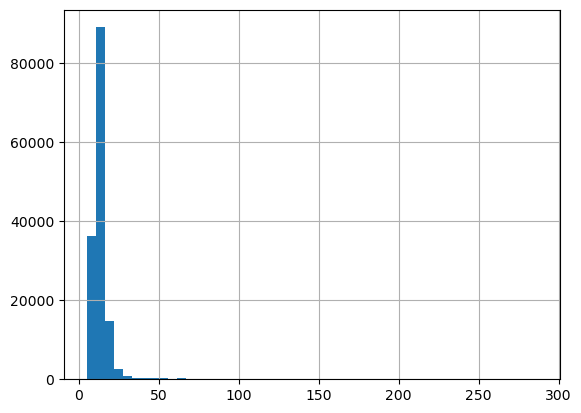

In [26]:
# Convert it to pandas and check the total_amount histogram
df_pandas = df.toPandas()

df_pandas["total_amount"].hist(bins = 50)
import matplotlib.pyplot as plt
plt.show()

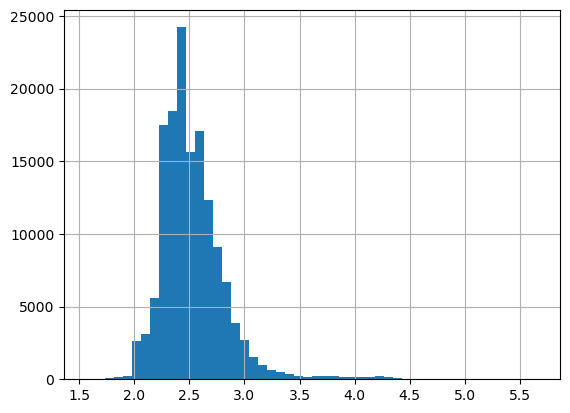

In [27]:
# By checking the above histogram, noted the total_amount has a long tail
# Try to use log transformation to see if the data could be better normorlized
from pyspark.sql.functions import log
df = df.withColumn("log_total_amount", log("total_amount"))

df_pandas = df.toPandas()
df_pandas["log_total_amount"].hist(bins = 50)

plt.show()

In [28]:
df.select('is_weekday').describe().show()

+-------+------------------+
|summary|        is_weekday|
+-------+------------------+
|  count|            145603|
|   mean|0.8287054524975447|
| stddev|0.3767674354758265|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [29]:
# Data with log transformation are more normalized. Hence, drop the total_amount

# drop_cols = ["total_amount","day_of_week"]
drop_cols = ["total_amount"]
df = df.drop(*drop_cols)

In [30]:
df.printSchema()

root
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- trip: string (nullable = true)
 |-- is_weekday: integer (nullable = false)
 |-- log_total_amount: double (nullable = true)



## Data Transformation

In [31]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder,StandardScaler
from pyspark.ml import Pipeline

cat_string_columns = ["trip"]
cat_columns = ["trip_index", "is_weekday", "day_of_week", "hour"]
#cat_columns = ["trip_index", "is_weekday", "hour"]
#discrete_columns = ["trip_distance","elapsed_time"]

# Create string indexer to convert trip and is_weekday column from string to numeric
string_indexer = StringIndexer(inputCol="trip", outputCol="trip_index", handleInvalid='keep')

# Create onehot encoder to convert into sparse vector 
encoder = [OneHotEncoder(inputCol=column, outputCol=column+"_ohe") for column in cat_columns]

# Create a pipeline for transform the data
pipeline = Pipeline(stages=[string_indexer, *encoder])

pipeline_transformer = pipeline.fit(df)

pipeline_transformer.write().overwrite().save("pipelinetransformer")

In [32]:
df_transform = pipeline_transformer.transform(df).drop(*(cat_string_columns + cat_columns))

In [33]:
df_transform.show(10)

+------------------+---------------+--------------+---------------+--------------+
|  log_total_amount| trip_index_ohe|is_weekday_ohe|day_of_week_ohe|      hour_ohe|
+------------------+---------------+--------------+---------------+--------------+
|2.6871669901857858|(13,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[0],[1.0])|
|2.5447466501440172| (13,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[2],[1.0])|
| 2.731766727719526| (13,[8],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[2],[1.0])|
| 2.841998173611949| (13,[8],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[3],[1.0])|
| 2.876948737564024| (13,[8],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[4],[1.0])|
| 2.760009940032921| (13,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[3],[1.0])|
|2.8425810940598164|(13,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[6],[1.0])|
| 2.464703942470481|(13,[12],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[6],[1.0])|
|2.7763317085186157| (13,[1],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[6],[1.0])|
| 2.

## Pull features into vector

In [34]:
featureCols = [c for c in df_transform.columns if c != 'log_total_amount']

In [35]:
print(featureCols)

['trip_index_ohe', 'is_weekday_ohe', 'day_of_week_ohe', 'hour_ohe']


In [36]:
from pyspark.ml.feature import VectorAssembler
feature = VectorAssembler(inputCols=featureCols,outputCol="features")
feature_vector= feature.transform(df_transform)

In [37]:
feature_vector.show()

+------------------+---------------+--------------+---------------+---------------+--------------------+
|  log_total_amount| trip_index_ohe|is_weekday_ohe|day_of_week_ohe|       hour_ohe|            features|
+------------------+---------------+--------------+---------------+---------------+--------------------+
|2.6871669901857858|(13,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[0],[1.0])|(44,[11,17,21],[1...|
|2.5447466501440172| (13,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[2],[1.0])|(44,[5,17,23],[1....|
| 2.731766727719526| (13,[8],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[2],[1.0])|(44,[8,17,23],[1....|
| 2.841998173611949| (13,[8],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[3],[1.0])|(44,[8,17,24],[1....|
| 2.876948737564024| (13,[8],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[4],[1.0])|(44,[8,17,25],[1....|
| 2.760009940032921| (13,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[3],[1.0])|(44,[5,17,24],[1....|
|2.8425810940598164|(13,[11],[1.0])|     (1,[],[])|  (7

## Split the data into training and test set

In [ ]:
# Split the data into training and testing sets, ensuring that both 1 and 0 values of is_weekday are present in the training data
# train_data = df.filter((col("is_weekday") == 1) | (col("is_weekday") == 0)).sampleBy("is_weekday", fractions={0: 0.8, 1: 0.8}, seed=42)
# test_data = df.subtract(train_data)

In [38]:
(trainingData, testData) = feature_vector.randomSplit([0.8, 0.2],seed = 42)

## Model Prediction - Gradient Boosted Trees

In [39]:
from pyspark.ml.regression import GBTRegressor

# create a GBTRegressor object
gbt = GBTRegressor(featuresCol='features', labelCol='log_total_amount', maxIter=10)

# fit the model to the training data
gbt_model = gbt.fit(trainingData)

# make predictions on the test data
gbt_predictions = gbt_model.transform(testData)
gbt_predictions.select("prediction", "log_total_amount", "features").show()

23/03/31 15:23:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/03/31 15:23:01 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
+------------------+------------------+--------------------+
|        prediction|  log_total_amount|            features|
+------------------+------------------+--------------------+
|  2.78319921253041|1.5686159179138452|(44,[2,17,31],[1....|
| 2.793552715649291|1.5686159179138452|(44,[2,19,27],[1....|
| 2.950281946684088|1.5686159179138452|(44,[2,20,33],[1....|
|2.7510664616606366| 1.667706820558076|(44,[2,16,22],[1....|
|  2.78319921253041| 1.667706820558076|(44,[2,17,28],[1....|
|  2.78319921253041| 1.667706820558076|(44,[2,17,39],[1....|
|2.7852350246878625| 1.667706820558076|(44,[2,18,43],[1....|
| 2.793552715649291| 1.667706820558076|(44,[2,19,39],[1....|
| 2.780165176205698| 1.667706820558076|(44,[2,13,35],[1....|
| 2.780165176205698| 1

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator
# evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="log_total_amount", predictionCol="prediction")
rmse = evaluator.evaluate(gbt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.257192


In [41]:
from pyspark.sql.functions import exp

gbt_predictions = gbt_predictions.withColumn('predicted_total_amount', exp('prediction'))

In [42]:
gbt_predictions.select("prediction", "log_total_amount","predicted_total_amount", "features").show()
#gbt_predictions.show()

+------------------+------------------+----------------------+--------------------+
|        prediction|  log_total_amount|predicted_total_amount|            features|
+------------------+------------------+----------------------+--------------------+
|  2.78319921253041|1.5686159179138452|    16.170671698633075|(44,[2,17,31],[1....|
| 2.793552715649291|1.5686159179138452|     16.33896450520483|(44,[2,19,27],[1....|
| 2.950281946684088|1.5686159179138452|    19.111341348006736|(44,[2,20,33],[1....|
|2.7510664616606366| 1.667706820558076|    15.659323050026368|(44,[2,16,22],[1....|
|  2.78319921253041| 1.667706820558076|    16.170671698633075|(44,[2,17,28],[1....|
|  2.78319921253041| 1.667706820558076|    16.170671698633075|(44,[2,17,39],[1....|
|2.7852350246878625| 1.667706820558076|    16.203625681349088|(44,[2,18,43],[1....|
| 2.793552715649291| 1.667706820558076|     16.33896450520483|(44,[2,19,39],[1....|
| 2.780165176205698| 1.667706820558076|    16.121683646648478|(44,[2,13,35],

In [43]:
gbt_model.write().overwrite().save("gbtmodel")

## Model Prediction - Linear Regression

In [44]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
lr = LinearRegression(labelCol='log_total_amount', featuresCol="features")

lrModel = lr.fit(trainingData)
lr_prediction = lrModel.transform(testData)
lr_prediction.select("prediction", "log_total_amount", "features").show()


23/03/31 15:31:16 WARN Instrumentation: [a5f24133] regParam is zero, which might cause numerical instability and overfitting.


23/03/31 15:31:18 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
23/03/31 15:31:18 WARN Instrumentation: [a5f24133] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


+------------------+------------------+--------------------+
|        prediction|  log_total_amount|            features|
+------------------+------------------+--------------------+
| 2.809441660249181|1.5686159179138452|(44,[2,17,31],[1....|
|2.8225083565185534|1.5686159179138452|(44,[2,19,27],[1....|
|2.8434016523272665|1.5686159179138452|(44,[2,20,33],[1....|
| 2.691757619702204| 1.667706820558076|(44,[2,16,22],[1....|
| 2.811140429874409| 1.667706820558076|(44,[2,17,28],[1....|
| 2.806774964115244| 1.667706820558076|(44,[2,17,39],[1....|
|2.8656160882266297| 1.667706820558076|(44,[2,18,43],[1....|
|2.8280906851478225| 1.667706820558076|(44,[2,19,39],[1....|
|2.7451975611783883| 1.667706820558076|(44,[2,13,35],[1....|
|2.7451975611783883| 1.667706820558076|(44,[2,13,35],[1....|
| 2.725938944843238| 1.667706820558076|(44,[2,13,15,27],...|
| 2.727036156882318| 1.667706820558076|(44,[2,13,15,36],...|
| 2.714666229121758| 1.667706820558076|(44,[2,13,15,38],...|
| 2.744050389110839| 1.7

In [45]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="log_total_amount", predictionCol="prediction")
rmse = evaluator.evaluate(lr_prediction)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.25723


In [46]:
spark.stop()